# Compute smoother centerlines

This notebook describes how to compute centerlines with OGGM and write them to disk. It is meant for users who are mostly interested in the centerlines, not so much the rest of the model.

We use an example of a user-provided glacier inventory and DEM (thanks to [Liss Andreassen](https://www.nve.no/hydrology/our-researchers/liss-marie-andreassen/) for providing the data).

In [1]:
import rioxarray as rioxr
import geopandas as gpd
import matplotlib.pyplot as plt

from oggm import cfg, utils, workflow, tasks

## Data preparation

In [2]:
fpath_inventory = 'zip://BreFlate20182019.zip/BreFlate20182019.shp'
fpath_dem = 'norgedtm10nov21.tif'

Read the data

In [3]:
inventory = gpd.read_file(fpath_inventory)

In this inventory, a few geometries have a topological error (the figure of eight where the outlines touch):

In [4]:
inventory.loc[~inventory.is_valid]

objektType  breID         brenavn  breType  areal_km2  forstedata  \
8          None   3161            None        0       0.02  2019-08-27   
92         None   1956            None        0       0.18  2019-08-27   
159        None   2456            None        0       0.19  2019-08-27   
387        None   2605        Liabreen        0       0.62  2019-08-27   
523        None   2656   Fannaråkbreen        0       2.75  2019-08-27   
...         ...    ...             ...      ...        ...         ...   
6643   Breflate   2290            None        0      11.41  2019-08-27   
6649   Breflate   2306      Flatebreen        0       0.40  2019-08-27   
6719   Breflate   2266     Lodalsbreen        0       8.76  2019-08-27   
6721   Breflate   2237            None        0       0.59  2019-08-27   
6725   Breflate   6762  Storefonnbreen        0       0.93  2019-08-27   

     datakilde metode sceneID  hovedbreID  ...  vassdragsO  FTEMA GlobalID  \
8         None   None      47           0  ...        None      0     None   
92        None   None      47           0  ...        None      0     None   
159       None   None      47           0  ...        None      0     None   
387       None   None      47           0  ...        None      0     None   
523       None   None      47           0  ...        None      0     None   
...        ...    ...     ...         ...  ...         ...    ...      ...   
6643      None   None      45           7  ...        None      0     None   
6649      None   None      45        2059  ...        None      0     None   
6719      None   None      45           1  ...        None      0     None   
6721      None   None      45           0  ...        None      0     None   
6725      None   None      45           1  ...        None      0     None   

      created_us  created_da last_edite  last_edi_1    Shape_STAr  \
8         FS_BRE  2021-11-12     FS_BRE  2021-11-12  2.248363e+04   
92        FS_BRE  2021-11-12     FS_BRE  2021-11-12  1.826024e+05   
159       FS_BRE  2021-11-12     FS_BRE  2021-11-12  1.932463e+05   
387       FS_BRE  2021-11-12     FS_BRE  2021-11-12  6.171481e+05   
523       FS_BRE  2021-11-12     FS_BRE  2021-11-12  2.747803e+06   
...          ...         ...        ...         ...           ...   
6643      FS_BRE  2021-11-12     FS_BRE  2021-11-12  1.141095e+07   
6649      FS_BRE  2021-11-12     FS_BRE  2021-11-12  4.046787e+05   
6719      FS_BRE  2021-11-12     FS_BRE  2021-11-12  8.758818e+06   
6721      FS_BRE  2021-11-12     FS_BRE  2021-11-12  5.943676e+05   
6725      FS_BRE  2021-11-12     FS_BRE  2021-11-12  9.274839e+05   

        Shape_STLe                                           geometry  
8      1021.901894  POLYGON ((100216.542 6912509.442, 100236.493 6...  
92     4047.790603  POLYGON ((92498.356 6900920.848, 92500.210 690...  
159    4669.023657  POLYGON ((91962.885 6883230.562, 91965.661 688...  
387    6595.974453  POLYGON ((120594.079 6853553.546, 120595.925 6...  
523   15241.345864  POLYGON ((124543.417 6842414.252, 124543.816 6...  
...            ...                                                ...  
6643  24954.300295  POLYGON ((63155.410 6869314.958, 63181.449 686...  
6649   5277.768078  POLYGON ((63964.380 6864753.248, 63965.304 686...  
6719  42808.850408  POLYGON ((91018.242 6874020.521, 90986.386 687...  
6721   6680.173218  POLYGON ((88863.476 6878889.301, 88873.452 687...  
6725   9173.311529  POLYGON ((89582.043 6864493.669, 89582.967 686...  

[67 rows x 22 columns]

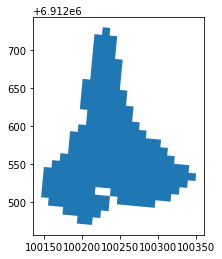

In [5]:
inventory.loc[~inventory.is_valid].iloc[[0]].plot();

Let's correct them:

In [6]:
inventory.loc[~inventory.is_valid, 'geometry'] = inventory.loc[~inventory.is_valid].buffer(0)

A final preparation step is to convert the format of the inventory to a file which resembles the RGI (see [use_your_own_inventory.ipynb](use_your_own_inventory.ipynb)):

In [7]:
# We keep the original ID for later reference
gdf = utils.cook_rgidf(inventory, o1_region='08', assign_column_values={'breID':'breID'})

## Compute the centerlines

We use the standard OGGM procedure for this:

In [8]:
cfg.initialize(logging_level='WARNING')

# Parameters
cfg.PARAMS['use_multiprocessing'] = False  # True is often a good idea but not here 
cfg.PARAMS['continue_on_error'] = True  # Yeah, shit happens
cfg.PARAMS['use_rgi_area'] = False  # this is required for user-defined inventories
cfg.PARAMS['use_intersects'] = False  # we don't care about intersects for centerlines
cfg.PARAMS['border'] = 10  # no need to make a large map

# Optional: change the grid resolution
# E.g. fixed grid spacing
# cfg.PARAMS['grid_dx_method'] = 'fixed'
# cfg.PARAMS['fixed_dx'] = 10
# Or variable but twice higher than default 
cfg.PARAMS['grid_dx_method'] = 'square'
cfg.PARAMS['d1'] = 7  # (default is 14)
cfg.PARAMS['d2'] = 5  # (default is 10)
cfg.PARAMS['dmax'] = 100  # (default is 200)

# Tell OGGM to use our user DEM (important!)
cfg.PATHS['dem_file'] = fpath_dem

# Where to work
cfg.PATHS['working_dir'] = 'wd_2xdefres'

2022-01-05 21:19:34: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-01-05 21:19:34: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-01-05 21:19:34: oggm.cfg: Multiprocessing: using all available processors (N=32)
100% of  22.3 MiB |######################| Elapsed Time: 0:00:02 Time:  0:00:02
2022-01-05 21:19:38: oggm.cfg: PARAMS['use_rgi_area'] changed from `True` to `False`.
2022-01-05 21:19:38: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.
2022-01-05 21:19:38: oggm.cfg: PARAMS['border'] changed from `40` to `10`.
2022-01-05 21:19:38: oggm.cfg: PARAMS['d1'] changed from `14.0` to `7`.
2022-01-05 21:19:38: oggm.cfg: PARAMS['d2'] changed from `10.0` to `5`.
2022-01-05 21:19:38: oggm.cfg: PARAMS['dmax'] changed from `200.0` to `100`.


Now the workflow: 

In [11]:
# gdirs = workflow.init_glacier_directories(gdf)

# workflow.execute_entity_task(tasks.define_glacier_region, gdirs, source='USER');  # Use the user DEM

workflow.execute_entity_task(tasks.glacier_masks, gdirs);
workflow.execute_entity_task(tasks.compute_centerlines, gdirs);

2022-01-05 22:10:42: oggm.workflow: Execute entity tasks [glacier_masks] on 6744 glaciers
2022-01-05 22:10:42: oggm.workflow: WARNING: you are trying to run an entity task on 6744 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2022-01-05 22:15:32: oggm.core.gis: InvalidDEMError occurred during task glacier_masks on RGI60-08.01696: (RGI60-08.01696) min equal max in the masked DEM.
2022-01-05 22:32:52: oggm.workflow: Execute entity tasks [compute_centerlines] on 6744 glaciers
2022-01-05 22:32:52: oggm.workflow: WARNING: you are trying to run an entity task on 6744 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.


**Note: the default in OGGM is to use a grid size of varying resolution for each glacier. I think it makes sense in many cases, but you may prefer to use the native resolution of your DEM. You can do so by commenting / un-commenting the options above.**

## Write the data to a shapefile: optional smoothing

The relevant task is "write_centerlines_to_shape", which writes everything to a shapefile:

In [15]:
from oggm.utils import write_centerlines_to_shape

write_centerlines_to_shape(gdirs,  # The glaciers to process
                           path='outputs/Norway_Centerlines_default.shp',  # The output file
                           to_tar=True,  # set to True to put everything into one single tar file
                           to_crs=inventory.crs,  # Write into the projection of the original inventory
                           keep_main_only=True,  # Write only the main flowline and discard the tributaries
                          )

2022-01-05 22:46:43: oggm.utils: Applying global task write_centerlines_to_shape on 6744 glaciers
2022-01-05 22:46:43: oggm.utils: write_centerlines_to_shape on outputs/Norway_Centerlines_default.shp ...
2022-01-05 22:46:43: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 6744 glaciers
2022-01-05 22:46:43: oggm.workflow: WARNING: you are trying to run an entity task on 6744 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.


Let's have a look at the output:

In [16]:
cls_default = gpd.read_file('tar://outputs/Norway_Centerlines_default.tar.gz/Norway_Centerlines_default.shp')
cls_default['breID'] = gdf['breID']  # This only works this way because we have one centerline per glacier!

cls_default.head()

RGIID  SEGMENT_ID  LE_SEGMENT  MAIN  \
0  RGI60-08.00001           0       322.0     1   
1  RGI60-08.00002           0       358.0     1   
2  RGI60-08.00003           0       314.0     1   
3  RGI60-08.00004           0       332.0     1   
4  RGI60-08.00005           0       215.0     1   

                                            geometry  breID  
0  LINESTRING (118270.857 6914371.200, 118278.618...   1855  
1  LINESTRING (118573.658 6913783.719, 118579.630...   3156  
2  LINESTRING (117411.558 6913657.999, 117412.239...   3157  
3  LINESTRING (117804.659 6913611.777, 117809.950...   1859  
4  LINESTRING (138401.165 6909220.080, 138407.784...   3158

`LE_SEGMENT` is the length of the centerline in meters. The RGI "IDs" are fake (OGGM needs them) but the breID are real. Lets use them as index for the file:

In [17]:
cls_default = cls_default.set_index('breID')
orig_inventory = inventory.set_index('breID')

Now we can plot an example:

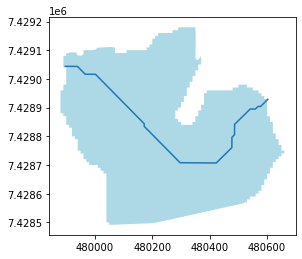

In [18]:
sel_breID = 1189  # 5570

f, ax = plt.subplots(figsize=(9, 4))
orig_inventory.loc[[sel_breID]].plot(ax=ax, facecolor='lightblue');
cls_default.loc[[sel_breID]].plot(ax=ax);

What can we see?

- the centerline does not end *exactly* at the glacier outline
- the line seems "crooked", it has sudden turns

Both effects are due to the algorithm we use to compute the centerlines ([Kienholz et al., (2014)](https://tc.copernicus.org/articles/8/503/2014/)),
which works on the underlying glacier grid. Each vertice (point) in the line corresponds to the center of the grid point.

**We have implemented new options in OGGM v1.6, which allow to circumvent these limitations**. We illustrate them here:

In [19]:
write_centerlines_to_shape(gdirs,  # The glaciers to process
                           path='outputs/Norway_Centerlines_smooth.shp',  # The output file
                           to_tar=True,  # set to True to put everything into one single tar file
                           to_crs=inventory.crs,  # Write into the projection of the original inventory
                           keep_main_only=True,  # Write only the main flowline and discard the tributaries
                           ensure_exterior_match=True,  # NEW! Ensure that the lines are touching the outlines
                           simplify_line=0.5,  # NEW! this option reduces the number of vertices along the line
                           corner_cutting=5,  # NEW! this then augments the number of vertices again
                          )

2022-01-05 22:55:51: oggm.utils: Applying global task write_centerlines_to_shape on 6744 glaciers
2022-01-05 22:55:51: oggm.utils: write_centerlines_to_shape on outputs/Norway_Centerlines_smooth.shp ...
2022-01-05 22:55:51: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 6744 glaciers
2022-01-05 22:55:51: oggm.workflow: WARNING: you are trying to run an entity task on 6744 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.


The `simplify_line` and `corner_cutting` options are cosmetic and subjective. The former will simplify the line, by making it look less edgy but also less precise, while the latter then "smoothes" it. Users may try different combinations to see their effect (see the [documentation](https://docs.oggm.org/en/latest/generated/oggm.global_tasks.write_centerlines_to_shape.html)).

In [22]:
cls_smooth = gpd.read_file('tar://outputs/Norway_Centerlines_smooth.tar.gz/Norway_Centerlines_smooth.shp')
cls_smooth['breID'] = gdf['breID']
cls_smooth = cls_smooth.set_index('breID')

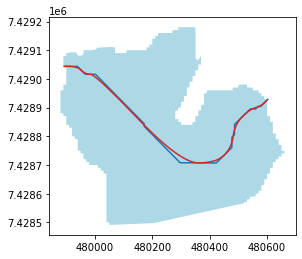

In [23]:
sel_breID = 1189

f, ax = plt.subplots(figsize=(9, 4))
orig_inventory.loc[[sel_breID]].plot(ax=ax, facecolor='lightblue');
cls_default.loc[[sel_breID]].plot(ax=ax);
cls_smooth.loc[[sel_breID]].plot(ax=ax, color='C3');

## Final remarks

While the centerline algorithm is quite robust, the results will vary as a function of the resolution of the underlying grid, and the smoothing options. After trying a little, it seems difficult to find a setting which works "best" in all circumstances, and we encourage users to try several options and see what they prefer.

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)